# Baseline Experiments & Results

## 1. Imports & Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

RANDOM_SEED = 42

## 2. Load Cleaned Diabetes Dataset

In [4]:
df = pd.read_csv('../data/diabetes_raw_data.csv') 

print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (1879, 45)


,PatientID,Age,Gender,Ethnicity,SocioeconomicStatus,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,...,SlowHealingSores,TinglingHandsFeet,QualityOfLifeScore,HeavyMetalsExposure,OccupationalExposureChemicals,WaterQuality,MedicalCheckupsFrequency,MedicationAdherence,HealthLiteracy,Diagnosis
0,6000,44,0,1,2,1,32.985284,1,4.499365,2.443385,...,0,1,73.765109,0,0,0,1.782724,4.486980,7.211349,1
1,6001,51,1,0,1,2,39.916764,0,1.578919,8.301264,...,0,0,91.445753,0,0,1,3.381070,5.961705,5.024612,1
2,6002,89,1,0,1,3,19.782251,0,1.177301,6.103395,...,0,0,54.485744,0,0,0,2.701019,8.950821,7.034944,0
3,6003,21,1,1,1,2,32.376881,1,1.714621,8.645465,...,0,0,77.866758,0,0,1,1.409056,3.124769,4.717774,0
4,6004,27,1,0,1,3,16.808600,0,15.462549,4.629383,...,0,0,37.731808,0,0,0,1.218452,6.977741,7.887940,0


## 3. Prepare Features and Target Variable

In [6]:
X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

print("Features:", list(X.columns))

Features: ['PatientID', 'Age', 'Gender', 'Ethnicity', 'SocioeconomicStatus', 'EducationLevel', 'BMI', 'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'FamilyHistoryDiabetes', 'GestationalDiabetes', 'PolycysticOvarySyndrome', 'PreviousPreDiabetes', 'Hypertension', 'SystolicBP', 'DiastolicBP', 'FastingBloodSugar', 'HbA1c', 'SerumCreatinine', 'BUNLevels', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'AntihypertensiveMedications', 'Statins', 'AntidiabeticMedications', 'FrequentUrination', 'ExcessiveThirst', 'UnexplainedWeightLoss', 'FatigueLevels', 'BlurredVision', 'SlowHealingSores', 'TinglingHandsFeet', 'QualityOfLifeScore', 'HeavyMetalsExposure', 'OccupationalExposureChemicals', 'WaterQuality', 'MedicalCheckupsFrequency', 'MedicationAdherence', 'HealthLiteracy']


## 4. Train-Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    shuffle=True,
    random_state=RANDOM_SEED
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 1503
Testing samples: 376


## 5. Scale Features

In [9]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 6. Baseline Classification with All Features

In [10]:
clf = DecisionTreeClassifier(random_state=RANDOM_SEED)

clf.fit(X_train_scaled, y_train)

print("Baseline Model Trained.")

Baseline Model Trained.


## 7. Evaluate Baseline Model

In [11]:
y_pred = clf.predict(X_test_scaled)

baseline_accuracy = accuracy_score(y_test, y_pred)

print(f"--- BASELINE RESULTS ---")
print(f"Accuracy: {baseline_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

--- BASELINE RESULTS ---
Accuracy: 0.9202

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       226
           1       0.91      0.89      0.90       150

    accuracy                           0.92       376
   macro avg       0.92      0.92      0.92       376
weighted avg       0.92      0.92      0.92       376



## 8. plot Feature Importance

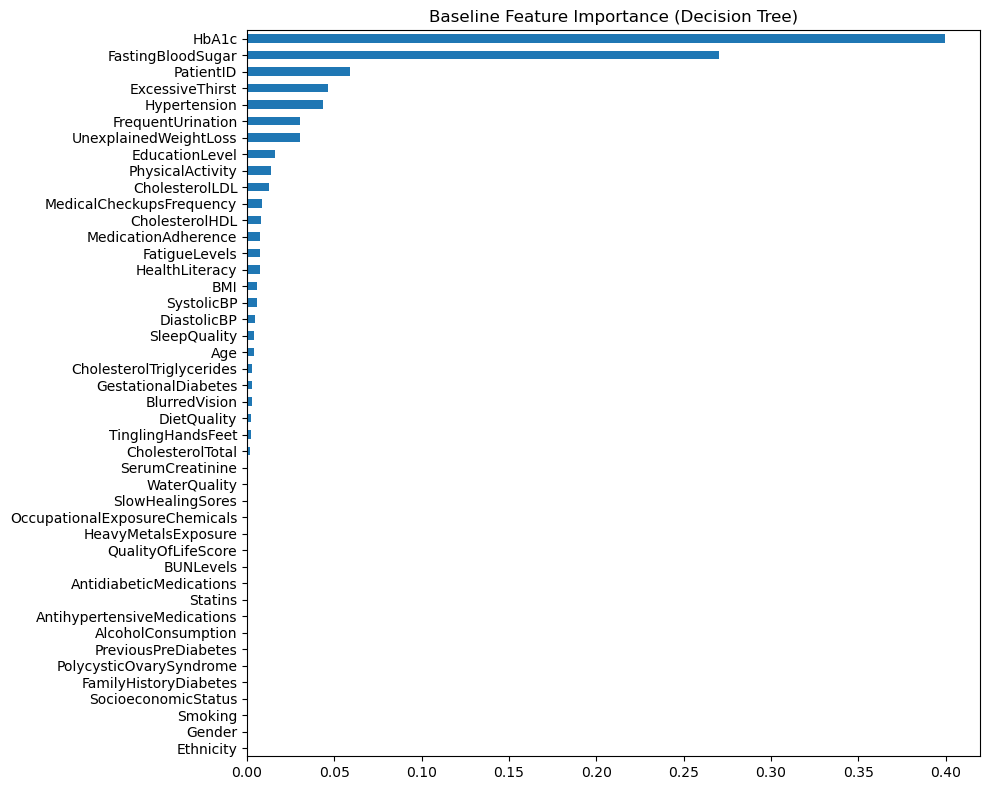

In [12]:
plt.figure(figsize=(10, 8))
importances = pd.Series(clf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh')
plt.title('Baseline Feature Importance (Decision Tree)')
plt.tight_layout()
plt.show()